In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss
from utils import Metrics, find_threshold, DataSet, Logger
from torch.utils.data import DataLoader
from torchviz import make_dot

In [2]:
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)

test = files["test"]
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)

In [3]:
traindataset = DataSet(samples=train[::,1:-1],
                       labels=train[::,-1].astype('int32'),
                       m = 2*train[::,0]-1)
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val[:,-1].astype('int32'),
                    m = 2*val[:,0]-1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('device:', device)

device: cpu


In [11]:
training_generator = DataLoader(traindataset, batch_size=4096, shuffle=True,num_workers=6,drop_last=True)
for i,(x,y,m) in enumerate(training_generator):
    print(m.sort())
    if i==2:
        break

torch.return_types.sort(
values=tensor([-0.9999, -0.9983, -0.9983,  ...,  0.5398,  0.6330,  0.6357]),
indices=tensor([3875, 1541, 4012,  ..., 3716, 3899,  855]))
torch.return_types.sort(
values=tensor([-0.9997, -0.9997, -0.9996,  ...,  0.6089,  0.6197,  0.7692]),
indices=tensor([2515, 1769, 1283,  ..., 3914, 2572,  792]))
torch.return_types.sort(
values=tensor([-0.9995, -0.9995, -0.9994,  ...,  0.5729,  0.5907,  0.6356]),
indices=tensor([1106, 2542, 3499,  ..., 3315, 4065, 4019]))


In [4]:
def plot_stuff(model,X,y,x_biased,name='Naive DNN',nbins=50,equalbins=False):
    predictions = np.array(model(torch.Tensor(X).float()).tolist()).flatten()
    metrics_test = Metrics(validation=True)
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]
    
    validation_predictions = np.array(model.yhat_val.tolist()).flatten()
    c = find_threshold(predictions,(y==0),0.5)
    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(validation_predictions,(val[:,-1]==0),eff))
    
    m_mat = np.sort(x_biased[y==1]).reshape(nbins,-1) 
    m = m_mat.mean(axis=1)#(bins[:-1]+bins[1:])*0.5
    if equalbins == True:
        bins = nbins
    else:
        bins = [m_mat.min()]
        bins.extend(m_mat[:,-1])
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    cB,_,_ = ax.hist(x_biased[y==1],bins=bins,alpha=0.3,color='C1',label='Background',density=False,log=False)
    cFP,_,_   = ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=False,log=False)
    ax.set_ylabel("Counts",fontsize=14)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    predictions = np.array(model(torch.Tensor(X[y==1]).float()).tolist()).flatten()
    scores = predictions[np.argsort(x_biased[y==1])].reshape(nbins,-1)
    for j,cut in enumerate(cuts):
        color = f"C{j}" #if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=color,lw=1)
    ax1.set_ylim([-0.02,1.02])
    ax1.set_ylabel("False Positives/events in bin",fontsize=14)
    ax1.set_xlabel(r"$m$",fontsize=14)
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=3)
    fig.tight_layout(pad=0)
    plt.show()

In [5]:
frac=0.97
print("strength",frac/(1-frac))
params = {'epochs'     : 200,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }
metrics_train_L = Metrics()
metrics_val_L = Metrics(validation=True)

strength 32.33333333333331


Entering Training...
Epoch:0100/0200  (129.2s)
 Train: loss:0.0694, acc:70% || Val: loss: 0.0487, acc:75%, R50: 9.1334, 1/JSD: 18.9598
Epoch:0200/0200  (270.3s)
 Train: loss:0.0665, acc:70% || Val: loss: 0.0460, acc:70%, R50: 7.5728, 1/JSD: 96.2522


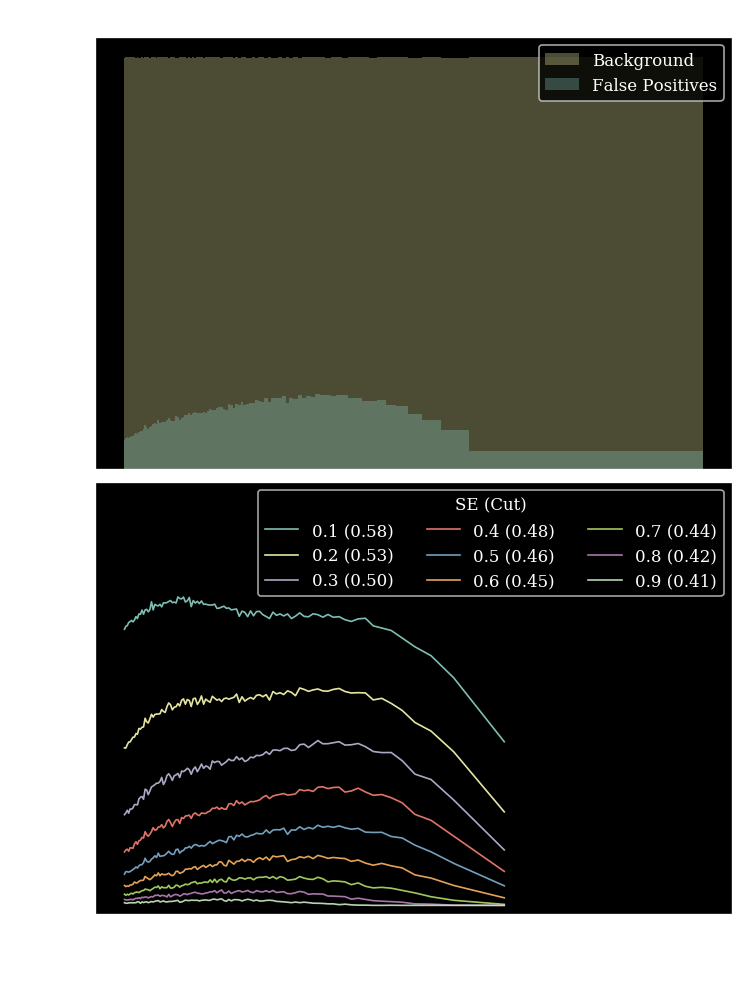

In [6]:
torch.manual_seed(69)
model1 = Classifier().to(device)
optimizer = torch.optim.SGD(model1.parameters(),lr=1e-1,momentum=0.)
loss =  FlatLoss(labels=traindataset.labels,frac=frac,order=0,sbins=50,bins=32,background_only=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.5)
log=Logger("./logs/logWFCNflatO1_.txt")
model1.fit(traindataset=traindataset,
            valdataset=valdataset,
            optimizer=optimizer,
            loss=loss,
            **params,
            log=log,
          #scheduler=scheduler,
          )
plot_stuff(model=model1,name="Order1 DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0],nbins=100)

Entering Training...
Epoch:0100/0200  (144.4s)
 Train: loss:0.0694, acc:70% || Val: loss: 0.0487, acc:75%, R50: 9.1334, 1/JSD: 18.9598
Epoch:0200/0200  (295.8s)
 Train: loss:0.0665, acc:70% || Val: loss: 0.0460, acc:70%, R50: 7.5728, 1/JSD: 96.2522


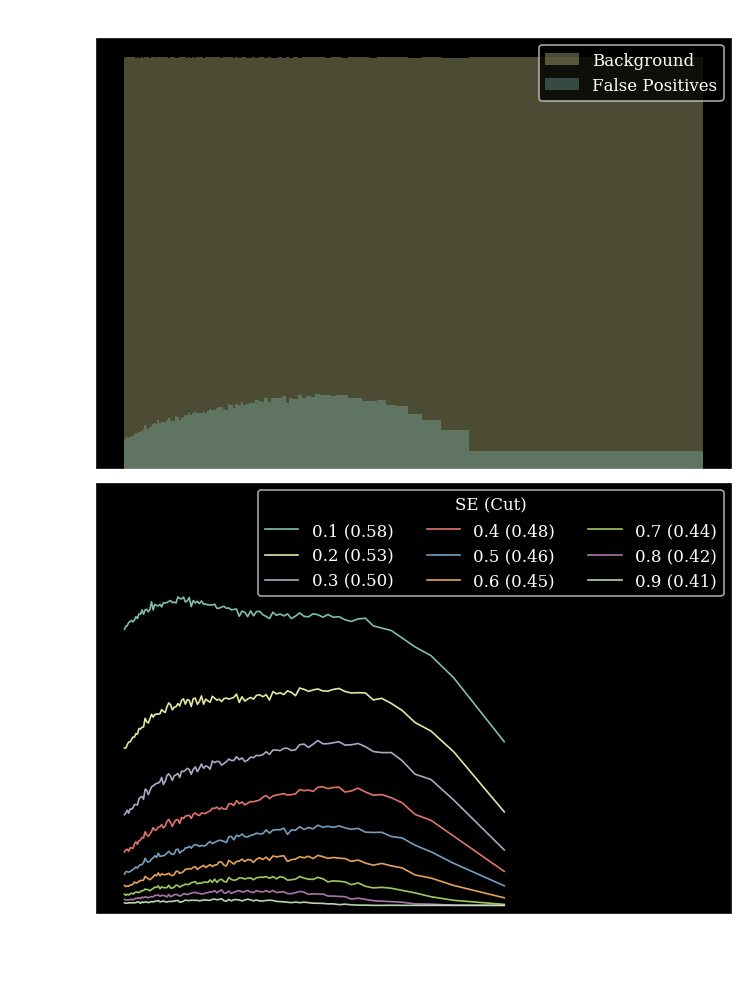

In [7]:
torch.manual_seed(69)
model0 = Classifier().to(device)
optimizer = torch.optim.SGD(model0.parameters(),lr=1e-1,momentum=0.)
loss =  FlatLoss(labels=traindataset.labels,frac=frac,order=0,sbins=50)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.5)
log=Logger("./logs/logWFCNflatO0_.txt")
model0.fit(traindataset=traindataset,
            valdataset=valdataset,
            optimizer=optimizer,
            loss=loss,
            **params,
            log=log,
          #scheduler=scheduler,
          )
plot_stuff(model=model0,name="Order0 DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0],nbins=100)

Entering Training...
Epoch:0100/0200  (152.7s)
 Train: loss:0.1990, acc:70% || Val: loss: 0.0487, acc:75%, R50: 9.1334, 1/JSD: 18.9598
Epoch:0200/0200  (314.6s)
 Train: loss:0.1173, acc:70% || Val: loss: 0.0460, acc:70%, R50: 7.5728, 1/JSD: 96.2522


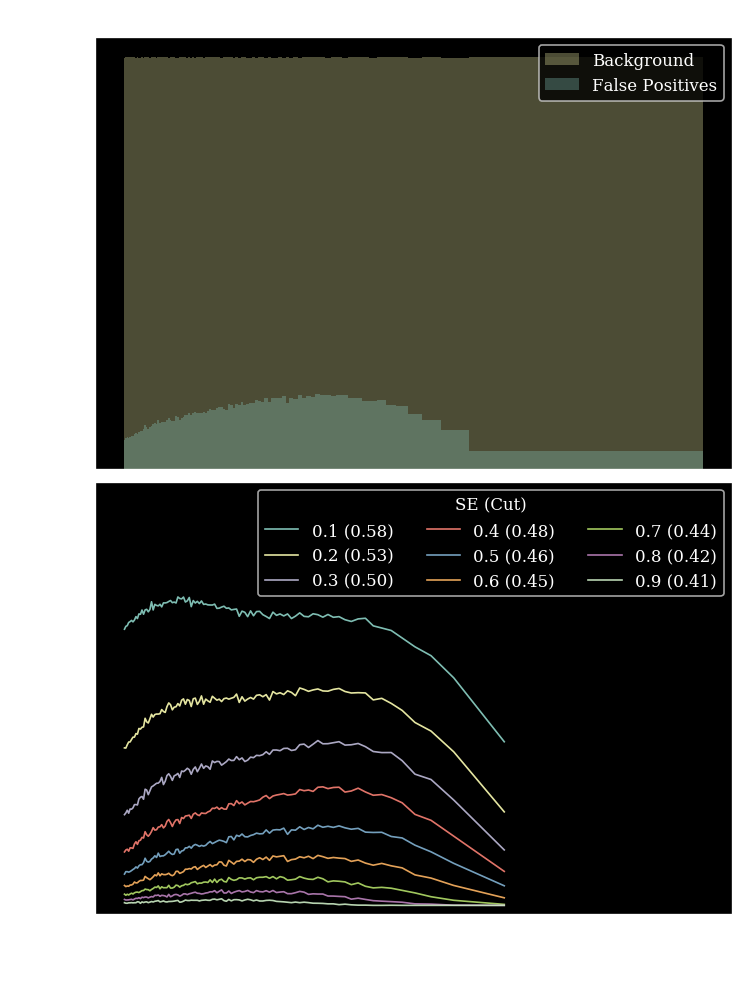

In [8]:
torch.manual_seed(69)
model2 = Classifier().to(device)
optimizer = torch.optim.SGD(model2.parameters(),lr=1e-1,momentum=0.)
loss =  FlatLoss(labels=traindataset.labels,frac=frac,order=2,sbins=50)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.5)
log=Logger("./logs/logWFCNflatO2_.txt")
model2.fit(traindataset=traindataset,
            valdataset=valdataset,
            optimizer=optimizer,
            loss=loss,
            **params,
            log=log,
          #scheduler=scheduler,
)
plot_stuff(model=model2,name="Order2 DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0],nbins=100)

In [9]:
params = {'epochs' : 200,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'pass_x_biased':False
         }
metrics_train = Metrics()
metrics_val = Metrics(validation=True)

In [10]:
torch.manual_seed(69)
model = Classifier()
optimizer = torch.optim.SGD(model.parameters(),lr=2e-1,momentum=0.)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
criterion = WeightedMSE(labels=traindataset.labels)
log=Logger("./logs/logWFCNmse.txt")
model.fit(traindataset=traindataset,
          valdataset=valdataset,
          **params,
          optimizer= optimizer,
          loss=criterion,
          log=log,
          #scheduler=scheduler,
          metrics=[metrics_train,metrics_val])

Entering Training...
Epoch:0100/0200  (141.3s)
 Train: loss:0.1891, acc:79% || Val: loss: 0.0335, acc:83%, R50: 22.4368, 1/JSD: 3.5423
Epoch:0200/0200  (286.5s)
 Train: loss:0.1876, acc:80% || Val: loss: 0.0305, acc:83%, R50: 23.9148, 1/JSD: 3.3657


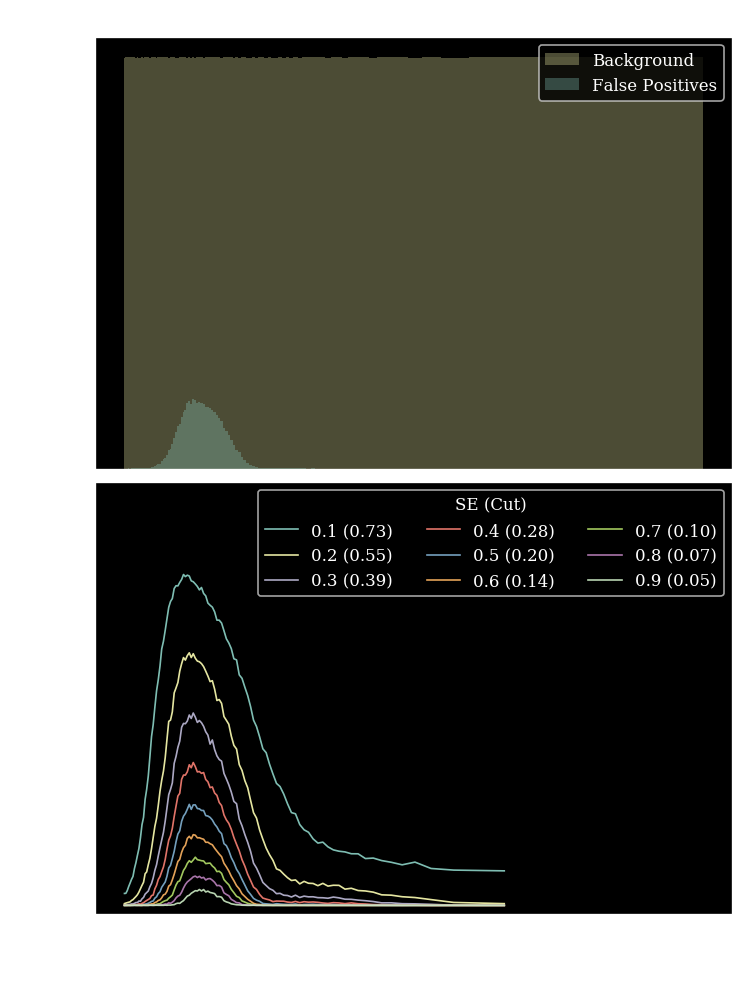

In [11]:
plot_stuff(model=model,name="Naive DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0],nbins=100)

In [12]:
binwidth = 10
nbins = 3
s = np.linspace(0,1,5).reshape(-1,1,1)
preds = np.random.uniform(0,1,(nbins,binwidth))
preds.sort(axis=1)
m = np.linspace(-1,1,binwidth*nbins).reshape(-1,binwidth)
dm = (m[:,-1]-m[:,0]).reshape(-1)
F = np.sum(preds<s,axis=2)/binwidth
F * dm

array([[0.        , 0.        , 0.        ],
       [0.12413793, 0.1862069 , 0.24827586],
       [0.31034483, 0.43448276, 0.37241379],
       [0.49655172, 0.49655172, 0.43448276],
       [0.62068966, 0.62068966, 0.62068966]])

In [13]:
a=np.linspace(0,1,10)
b=np.linspace(0,1,5).reshape(-1,1)
(a*b).shape

(5, 10)

In [ ]:
frac=0.97
print("strength",frac/(1-frac))
params = {'epochs'     : 200,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }
metrics_train_L = Metrics()
metrics_val_L = Metrics(validation=True)
torch.manual_seed(69)
model1 = Classifier().to(device)
optimizer = torch.optim.SGD(model1.parameters(),lr=1e-1,momentum=0.)
loss =  FlatLoss(labels=traindataset.labels,frac=frac,order=2,sbins=50,bins=32,background_only=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.5)
model1.fit(traindataset=traindataset,
            valdataset=valdataset,
            optimizer=optimizer,
            loss=loss,
            **params,
          #scheduler=scheduler,
          )

strength 32.33333333333331
Entering Training...
> /home/kitouni/UnbiasedML/UnbiasedML/models.py(302)__call__()
-> return legendre_loss
(Pdb) self.s
tensor([[[0.4991]],

        [[0.4992]],

        [[0.4993]],

        [[0.4994]],

        [[0.4996]],

        [[0.4997]],

        [[0.4998]],

        [[0.4999]],

        [[0.5000]],

        [[0.5001]],

        [[0.5003]],

        [[0.5004]],

        [[0.5005]],

        [[0.5006]],

        [[0.5007]],

        [[0.5008]],

        [[0.5009]],

        [[0.5011]],

        [[0.5012]],

        [[0.5013]],

        [[0.5014]],

        [[0.5015]],

        [[0.5016]],

        [[0.5017]],

        [[0.5019]],

        [[0.5020]],

        [[0.5021]],

        [[0.5022]],

        [[0.5023]],

        [[0.5024]],

        [[0.5026]],

        [[0.5027]],

        [[0.5028]],

        [[0.5029]],

        [[0.5030]],

        [[0.5031]],

        [[0.5032]],

        [[0.5034]],

        [[0.5035]],

        [[0.5036]],

        [[0.

In [ ]:
make_dot(l).render("logs/order2",format="svg")

In [ ]:
print([x.grad for i,(name, x) in enumerate(self.named_parameters()) if i==0])